In [1]:
import pygam
import pandas
import numpy
import numpy.random
import seaborn
import vtreat
import vtreat.util
import vtreat.transform

In [2]:
class GAMTransform(vtreat.transform.UserTransform):
    """a gam model"""
    def __init__(self):
        vtreat.transform.UserTransform.__init__(self, treatment='gam')
        self.models_ = None

    def fit(self, X, y):
        self.models_ = { 
            v:pygam.LinearGAM().fit(X[[v]], y) 
                for v in X.columns 
                if vtreat.util.can_convert_v_to_numeric(X[v])}
        self.incoming_vars_ = [v for v in self.models_.keys()]
        self.derived_vars_ = [(v + "_gam") for v in self.incoming_vars_]
        return self
        
    def transform(self, X):
        cols = {
            self.derived_vars_[i]:self.models_[self.incoming_vars_[i]].predict(X[[self.incoming_vars_[i]]]) 
                for i in range(len(self.incoming_vars_))}
        return pandas.DataFrame(cols)

In [3]:
d = pandas.DataFrame({'x':[i for i in range(100)]})
d['y'] = numpy.sin(0.2*d['x']) + 0.1*numpy.random.normal(size=d.shape[0])
d.head()

,x,y
0,0,-0.005548
1,1,0.241633
2,2,0.357987
3,3,0.618645
4,4,0.956208


In [4]:
step = GAMTransform()

In [5]:
fit = step.fit_transform(d[['x']], d['y'])
print(step.derived_vars_)
fit['x'] = d['x']
fit.head()

['x_gam']


,x_gam,x
0,0.334062,0
1,0.442623,1
2,0.543617,2
3,0.633579,3
4,0.709042,4


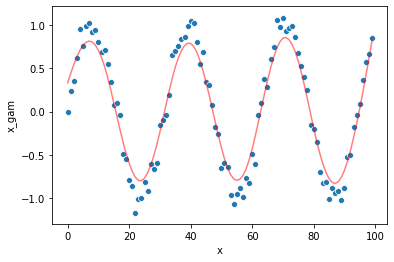

In [6]:
seaborn.scatterplot(x='x', y='y', data=d)
seaborn.lineplot(x='x', y='x_gam', data=fit, color='red', alpha=0.5)

In [7]:
transform = vtreat.NumericOutcomeTreatment(
    outcome_name='y',
    params = vtreat.vtreat_parameters({
       'user_transforms': [GAMTransform()]
    }))

In [8]:
x2 = transform.fit_transform(d, d['y'])

In [9]:
transform.score_frame_

,orig_variable,treatment,variable,y_aware,has_range,PearsonR,significance,vcount,recommended
0,x,clean_copy,x,False,True,-0.165511,9.983137e-02,1.0,True
1,x,gam,x_gam,True,True,0.977069,1.203906e-67,1.0,True


In [10]:
x2.head()

,y,x,x_gam
0,-0.005548,0.0,0.522557
1,0.241633,1.0,0.485600
2,0.357987,2.0,0.586407
3,0.618645,3.0,0.725493
4,0.956208,4.0,0.638325


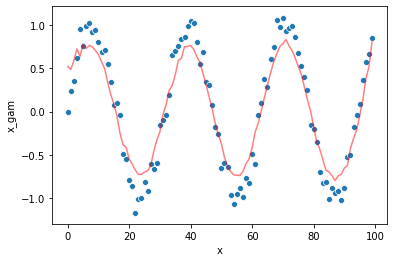

In [11]:
seaborn.scatterplot(x='x', y='y', data=x2)
seaborn.lineplot(x='x', y='x_gam', data=x2, color='red', alpha=0.5)

Notice the cross-fit is more ragged, simulating the expected lower performance on in-range but out-of-sample data. This is good: as it is porting difficulties we will see later back into the training environment, where we can try to do something about them.